In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("using", device)

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed(777)

using cuda


In [2]:
batch_size = 256
noise_dim = 100
epoch = 500

test_len = 10
test_num = 50

lr_G = 0.0002
lr_D = 0.0002
k = 1

In [3]:
mnist_train = torchvision.datasets.MNIST(
    root = '../MNIST_data',
    train = True, 
    transform = torchvision.transforms.ToTensor(), 
    download = True
)
"""
mnist_test = torchvision.datasets.MNIST(
    root = '../MNIST_data', 
    train = False, 
    transform = torchvision.transforms.ToTensor(), 
    download = True
)
"""

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST_data/MNIST/raw



"\nmnist_test = torchvision.datasets.MNIST(\n    root = '../MNIST_data', \n    train = False, \n    transform = torchvision.transforms.ToTensor(), \n    download = True\n)\n"

In [4]:
data_loader = torch.utils.data.DataLoader(
    dataset = mnist_train,
    shuffle = True,
    batch_size = batch_size,
    drop_last = True,
)

In [5]:
class discriminator(torch.nn.Module): # 28x28 size inputs -> true/false(classification)
    def __init__(self) -> None:
        super().__init__()
        self.act = torch.nn.LeakyReLU(0.2)
        self.conv1 = torch.nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.conv2 = torch.nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.batchnorm2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.Conv2d(128, 256, 3, 2, 1, bias=False)
        self.batchnorm3 = torch.nn.BatchNorm2d(256)
        self.conv4 = torch.nn.Conv2d(256, 1, 4, 1, 0, bias=False)
        self.sig = torch.nn.Sigmoid()
        
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.act(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.act(out)

        out = self.conv4(out)
        out = self.sig(out)
  
        out = out.view(-1)
        return out


In [6]:
class generator(torch.nn.Module): # 28x28 size inputs -> true/false(classification)
    def __init__(self, noisedim) -> None:
        super().__init__()
        self.noisedim = noisedim
        
        self.act = torch.nn.ReLU()
        self.conv1 = torch.nn.ConvTranspose2d(noise_dim, 256, 4, 1, 0, bias=False)
        self.batchnorm1 = torch.nn.BatchNorm2d(256)
        self.conv2 = torch.nn.ConvTranspose2d(256, 128, 3, 2, 1, bias=False)
        self.batchnorm2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.batchnorm3 = torch.nn.BatchNorm2d(64)
        self.conv4 = torch.nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)
        self.Tanh = torch.nn.Tanh()
        
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.act(out)

        out = self.conv4(out)
        out = self.Tanh(out)

        return out


In [7]:
def generate_noise(noisenum, noisedim):
    return torch.randn(noisenum, noisedim, 1, 1).to(device)

In [8]:
def generate_labels(labelnum):
    return torch.zeros(labelnum).to(device), torch.ones(labelnum).to(device)

In [9]:
G = generator(noise_dim).to(device) #generator
D = discriminator().to(device) #discriminator
criterion = torch.nn.BCELoss()
G_optim = torch.optim.Adam(G.parameters(), lr = lr_G)
D_optim = torch.optim.Adam(D.parameters(), lr = lr_D)
noise_for_print = generate_noise(test_len, noise_dim)
fake_labels, real_labels = generate_labels(batch_size)
print_per = epoch / test_num
idx = 1

EPOCH : 1 GLOSS: 6.960413932800293 DLOSS: 0.0043529337272048


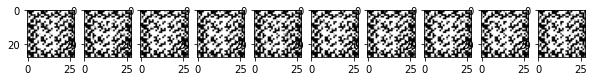

EPOCH : 2 GLOSS: 8.57629680633545 DLOSS: 0.0006323718116618693
EPOCH : 3 GLOSS: 8.953165054321289 DLOSS: 0.00035282765747979283
EPOCH : 4 GLOSS: 8.719555854797363 DLOSS: 0.0003161802887916565
EPOCH : 5 GLOSS: 9.916997909545898 DLOSS: 0.00016713955847080797
EPOCH : 6 GLOSS: 9.123741149902344 DLOSS: 0.0002308821422047913
EPOCH : 7 GLOSS: 9.236211776733398 DLOSS: 0.00026056350907310843
EPOCH : 8 GLOSS: 8.153656005859375 DLOSS: 0.0016757557168602943
EPOCH : 9 GLOSS: 10.822281837463379 DLOSS: 0.002026414731517434
EPOCH : 10 GLOSS: 10.5404052734375 DLOSS: 8.949262701207772e-05
EPOCH : 11 GLOSS: 9.597033500671387 DLOSS: 0.00031253238557837903


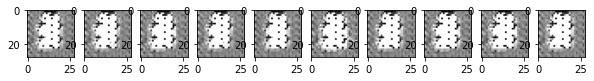

EPOCH : 12 GLOSS: 10.376824378967285 DLOSS: 7.285404717549682e-05
EPOCH : 13 GLOSS: 10.618062973022461 DLOSS: 0.0003515184507705271
EPOCH : 14 GLOSS: 9.967719078063965 DLOSS: 0.00023115769727155566
EPOCH : 15 GLOSS: 8.795610427856445 DLOSS: 0.0025740349665284157
EPOCH : 16 GLOSS: 11.219261169433594 DLOSS: 0.0007595338393002748
EPOCH : 17 GLOSS: 9.652225494384766 DLOSS: 0.001081598224118352
EPOCH : 18 GLOSS: 12.403820037841797 DLOSS: 0.0005687257507815957
EPOCH : 19 GLOSS: 12.33039665222168 DLOSS: 0.0021722172386944294
EPOCH : 20 GLOSS: 6.772421836853027 DLOSS: 0.017852213233709335
EPOCH : 21 GLOSS: 6.617705345153809 DLOSS: 0.010171771980822086


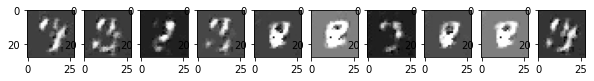

EPOCH : 22 GLOSS: 6.730923652648926 DLOSS: 0.005271896719932556
EPOCH : 23 GLOSS: 7.762901306152344 DLOSS: 0.002394369337707758
EPOCH : 24 GLOSS: 8.324382781982422 DLOSS: 0.0011945125879719853
EPOCH : 25 GLOSS: 8.81585693359375 DLOSS: 0.002511576982215047
EPOCH : 26 GLOSS: 7.174983024597168 DLOSS: 0.0041052657179534435
EPOCH : 27 GLOSS: 8.919377326965332 DLOSS: 0.0008347913972102106
EPOCH : 28 GLOSS: 7.679080009460449 DLOSS: 0.00200415076687932
EPOCH : 29 GLOSS: 8.883724212646484 DLOSS: 0.0008890720782801509
EPOCH : 30 GLOSS: 8.78919792175293 DLOSS: 0.0009823334403336048
EPOCH : 31 GLOSS: 8.721824645996094 DLOSS: 0.0012382704298943281


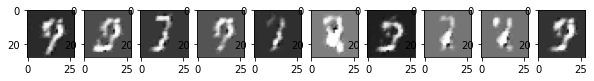

EPOCH : 32 GLOSS: 8.245738983154297 DLOSS: 0.0015070544322952628
EPOCH : 33 GLOSS: 8.998661041259766 DLOSS: 0.0013539280043914914
EPOCH : 34 GLOSS: 6.718012809753418 DLOSS: 0.014010773040354252
EPOCH : 35 GLOSS: 6.847415924072266 DLOSS: 0.005919414572417736
EPOCH : 36 GLOSS: 6.3099365234375 DLOSS: 0.005412101745605469
EPOCH : 37 GLOSS: 6.900422096252441 DLOSS: 0.006651580333709717
EPOCH : 38 GLOSS: 8.205709457397461 DLOSS: 0.0033831193577498198
EPOCH : 39 GLOSS: 7.254938125610352 DLOSS: 0.0024889535270631313
EPOCH : 40 GLOSS: 7.435275077819824 DLOSS: 0.0033310772851109505
EPOCH : 41 GLOSS: 8.575389862060547 DLOSS: 0.0020691065583378077


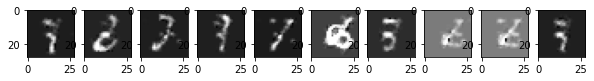

EPOCH : 42 GLOSS: 8.035491943359375 DLOSS: 0.001719132182188332
EPOCH : 43 GLOSS: 9.450698852539062 DLOSS: 0.0006000197608955204
EPOCH : 44 GLOSS: 8.293776512145996 DLOSS: 0.002261130604892969
EPOCH : 45 GLOSS: 8.743111610412598 DLOSS: 0.0028097969479858875
EPOCH : 46 GLOSS: 7.5205817222595215 DLOSS: 0.0032266152556985617
EPOCH : 47 GLOSS: 10.406013488769531 DLOSS: 0.0006905686459504068
EPOCH : 48 GLOSS: 9.707219123840332 DLOSS: 0.0020494998898357153
EPOCH : 49 GLOSS: 8.567855834960938 DLOSS: 0.0009083314216695726
EPOCH : 50 GLOSS: 10.783129692077637 DLOSS: 0.00024192771525122225
EPOCH : 51 GLOSS: 7.634806156158447 DLOSS: 0.0006972999544814229


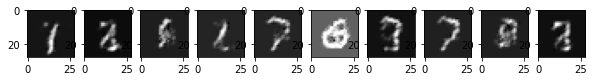

EPOCH : 52 GLOSS: 9.874818801879883 DLOSS: 0.00044343183981254697
EPOCH : 53 GLOSS: 11.138057708740234 DLOSS: 0.0009388906182721257
EPOCH : 54 GLOSS: 11.754077911376953 DLOSS: 0.00025931737036444247
EPOCH : 55 GLOSS: 9.976449012756348 DLOSS: 0.0003873943933285773
EPOCH : 56 GLOSS: 8.777440071105957 DLOSS: 0.0017637183191254735
EPOCH : 57 GLOSS: 9.361750602722168 DLOSS: 0.0009658795897848904
EPOCH : 58 GLOSS: 13.59715461730957 DLOSS: 0.00037153688026592135
EPOCH : 59 GLOSS: 7.734806537628174 DLOSS: 0.005136885680258274
EPOCH : 60 GLOSS: 8.472143173217773 DLOSS: 0.003205997869372368
EPOCH : 61 GLOSS: 7.863808631896973 DLOSS: 0.0026796781457960606


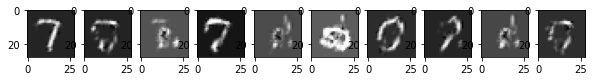

EPOCH : 62 GLOSS: 7.804654121398926 DLOSS: 0.0029137940146028996
EPOCH : 63 GLOSS: 7.5428690910339355 DLOSS: 0.005805677734315395
EPOCH : 64 GLOSS: 8.008544921875 DLOSS: 0.0023152180947363377
EPOCH : 65 GLOSS: 8.114112854003906 DLOSS: 0.0035821290221065283
EPOCH : 66 GLOSS: 7.686058044433594 DLOSS: 0.006279802415519953
EPOCH : 67 GLOSS: 10.7291898727417 DLOSS: 0.002026948379352689
EPOCH : 68 GLOSS: 9.105448722839355 DLOSS: 0.001878917682915926
EPOCH : 69 GLOSS: 8.314779281616211 DLOSS: 0.0014074740465730429
EPOCH : 70 GLOSS: 9.34003734588623 DLOSS: 0.0010329467477276921
EPOCH : 71 GLOSS: 8.54447078704834 DLOSS: 0.0020776335150003433


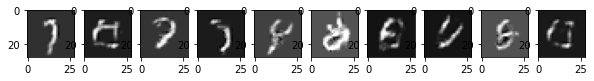

EPOCH : 72 GLOSS: 9.704283714294434 DLOSS: 0.004707967862486839
EPOCH : 73 GLOSS: 7.692460060119629 DLOSS: 0.001218388439156115
EPOCH : 74 GLOSS: 7.088281631469727 DLOSS: 0.003232556162402034
EPOCH : 75 GLOSS: 8.432170867919922 DLOSS: 0.040751032531261444
EPOCH : 76 GLOSS: 8.833460807800293 DLOSS: 0.002229582518339157
EPOCH : 77 GLOSS: 5.9586358070373535 DLOSS: 0.01255754753947258
EPOCH : 78 GLOSS: 6.612400054931641 DLOSS: 0.011301957070827484
EPOCH : 79 GLOSS: 6.928014755249023 DLOSS: 0.008913190104067326
EPOCH : 80 GLOSS: 8.648765563964844 DLOSS: 0.020919285714626312
EPOCH : 81 GLOSS: 7.2034010887146 DLOSS: 0.007005751132965088


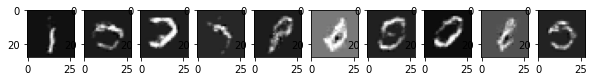

EPOCH : 82 GLOSS: 7.6257643699646 DLOSS: 0.005537603050470352
EPOCH : 83 GLOSS: 6.901980400085449 DLOSS: 0.00473991921171546
EPOCH : 84 GLOSS: 5.9902167320251465 DLOSS: 0.012888074852526188
EPOCH : 85 GLOSS: 7.642088890075684 DLOSS: 0.004533839412033558
EPOCH : 86 GLOSS: 6.833850383758545 DLOSS: 0.0072922417894005775
EPOCH : 87 GLOSS: 7.052496433258057 DLOSS: 0.0033679837360978127
EPOCH : 88 GLOSS: 7.8265485763549805 DLOSS: 0.007972474209964275
EPOCH : 89 GLOSS: 6.422521591186523 DLOSS: 0.10022329539060593
EPOCH : 90 GLOSS: 7.777683734893799 DLOSS: 0.014295900240540504
EPOCH : 91 GLOSS: 6.618651866912842 DLOSS: 0.01563127525150776


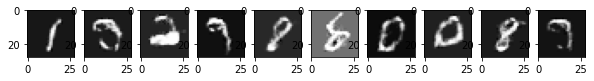

EPOCH : 92 GLOSS: 6.783369064331055 DLOSS: 0.010715099982917309
EPOCH : 93 GLOSS: 9.961629867553711 DLOSS: 0.006480866111814976
EPOCH : 94 GLOSS: 7.730402946472168 DLOSS: 0.00889925379306078
EPOCH : 95 GLOSS: 6.999070167541504 DLOSS: 0.006217670161277056
EPOCH : 96 GLOSS: 6.678647518157959 DLOSS: 0.006632344797253609
EPOCH : 97 GLOSS: 8.724069595336914 DLOSS: 0.0033945790491998196
EPOCH : 98 GLOSS: 7.998639106750488 DLOSS: 0.011202664114534855
EPOCH : 99 GLOSS: 5.51832389831543 DLOSS: 0.006159603595733643
EPOCH : 100 GLOSS: 6.461305618286133 DLOSS: 0.005829717498272657
EPOCH : 101 GLOSS: 7.509552955627441 DLOSS: 0.0026353353168815374


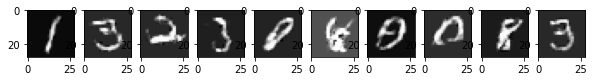

EPOCH : 102 GLOSS: 7.346311569213867 DLOSS: 0.0032390430569648743
EPOCH : 103 GLOSS: 7.153502464294434 DLOSS: 0.005437580402940512
EPOCH : 104 GLOSS: 11.202157020568848 DLOSS: 0.034386493265628815
EPOCH : 105 GLOSS: 8.692767143249512 DLOSS: 0.001620953786186874
EPOCH : 106 GLOSS: 7.686068534851074 DLOSS: 0.005283764563500881
EPOCH : 107 GLOSS: 7.449522495269775 DLOSS: 0.003929004538804293
EPOCH : 108 GLOSS: 8.094437599182129 DLOSS: 0.0063478536903858185
EPOCH : 109 GLOSS: 7.582850456237793 DLOSS: 0.00611993670463562
EPOCH : 110 GLOSS: 6.6442484855651855 DLOSS: 0.008366793394088745
EPOCH : 111 GLOSS: 5.6507368087768555 DLOSS: 0.022870806977152824


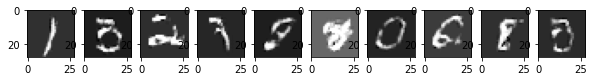

EPOCH : 112 GLOSS: 6.299004077911377 DLOSS: 0.025155536830425262
EPOCH : 113 GLOSS: 6.253584861755371 DLOSS: 0.011110307648777962
EPOCH : 114 GLOSS: 6.7608747482299805 DLOSS: 0.010631708428263664
EPOCH : 115 GLOSS: 7.181340217590332 DLOSS: 0.007521484047174454
EPOCH : 116 GLOSS: 7.230192184448242 DLOSS: 0.007384898606687784
EPOCH : 117 GLOSS: 6.158352375030518 DLOSS: 0.007352747023105621
EPOCH : 118 GLOSS: 7.002078056335449 DLOSS: 0.010666171088814735
EPOCH : 119 GLOSS: 6.077005386352539 DLOSS: 0.013013865798711777
EPOCH : 120 GLOSS: 6.571829319000244 DLOSS: 0.00832378026098013
EPOCH : 121 GLOSS: 6.47285795211792 DLOSS: 0.005552492570132017


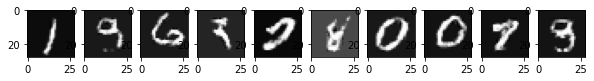

EPOCH : 122 GLOSS: 6.656978607177734 DLOSS: 0.008498339913785458
EPOCH : 123 GLOSS: 7.510588645935059 DLOSS: 0.005124443210661411
EPOCH : 124 GLOSS: 6.052559852600098 DLOSS: 0.01624290645122528
EPOCH : 125 GLOSS: 6.7585039138793945 DLOSS: 0.01329960860311985
EPOCH : 126 GLOSS: 6.364729881286621 DLOSS: 0.008272930979728699
EPOCH : 127 GLOSS: 6.470670700073242 DLOSS: 0.012679433450102806
EPOCH : 128 GLOSS: 5.576254844665527 DLOSS: 0.017053594812750816
EPOCH : 129 GLOSS: 6.318469047546387 DLOSS: 0.00962497666478157
EPOCH : 130 GLOSS: 6.100586414337158 DLOSS: 0.0105423079803586
EPOCH : 131 GLOSS: 5.951544761657715 DLOSS: 0.01008085161447525


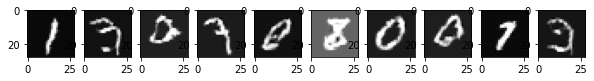

EPOCH : 132 GLOSS: 5.351077079772949 DLOSS: 0.018322778865695
EPOCH : 133 GLOSS: 7.198198318481445 DLOSS: 0.010002100840210915
EPOCH : 134 GLOSS: 7.7676191329956055 DLOSS: 0.010945988819003105
EPOCH : 135 GLOSS: 7.179346084594727 DLOSS: 0.009007828310132027
EPOCH : 136 GLOSS: 5.854282379150391 DLOSS: 0.009506402537226677
EPOCH : 137 GLOSS: 6.3027849197387695 DLOSS: 0.006699197459965944
EPOCH : 138 GLOSS: 7.5644073486328125 DLOSS: 0.008609225042164326
EPOCH : 139 GLOSS: 6.211411476135254 DLOSS: 0.006136423908174038
EPOCH : 140 GLOSS: 6.953203201293945 DLOSS: 0.008432885631918907
EPOCH : 141 GLOSS: 7.262685775756836 DLOSS: 0.011548841372132301


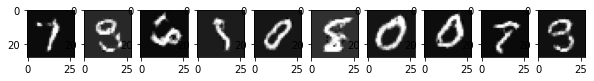

EPOCH : 142 GLOSS: 2.448685646057129 DLOSS: 1.833733320236206
EPOCH : 143 GLOSS: 5.408964157104492 DLOSS: 0.027462132275104523
EPOCH : 144 GLOSS: 6.358542442321777 DLOSS: 0.015623501501977444
EPOCH : 145 GLOSS: 5.579462051391602 DLOSS: 0.02965090237557888
EPOCH : 146 GLOSS: 5.791159629821777 DLOSS: 0.01035129651427269
EPOCH : 147 GLOSS: 5.726988315582275 DLOSS: 0.009561063721776009
EPOCH : 148 GLOSS: 5.724599838256836 DLOSS: 0.021001778542995453
EPOCH : 149 GLOSS: 7.541085720062256 DLOSS: 0.005991095677018166
EPOCH : 150 GLOSS: 6.123726844787598 DLOSS: 0.009132511913776398
EPOCH : 151 GLOSS: 7.550973892211914 DLOSS: 0.005534338764846325


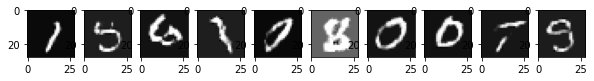

EPOCH : 152 GLOSS: 5.164421558380127 DLOSS: 0.02029557153582573
EPOCH : 153 GLOSS: 6.7068681716918945 DLOSS: 0.015242183580994606
EPOCH : 154 GLOSS: 7.667384147644043 DLOSS: 0.014131998643279076
EPOCH : 155 GLOSS: 5.959644317626953 DLOSS: 0.016182024031877518
EPOCH : 156 GLOSS: 6.646357536315918 DLOSS: 0.010667957365512848
EPOCH : 157 GLOSS: 6.5459489822387695 DLOSS: 0.010238165967166424
EPOCH : 158 GLOSS: 6.5990118980407715 DLOSS: 0.00473526306450367
EPOCH : 159 GLOSS: 8.6341552734375 DLOSS: 0.00817536748945713
EPOCH : 160 GLOSS: 5.622106075286865 DLOSS: 0.01597611978650093
EPOCH : 161 GLOSS: 6.070412635803223 DLOSS: 0.012664895504713058


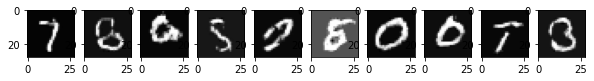

EPOCH : 162 GLOSS: 6.489999771118164 DLOSS: 0.012422988191246986
EPOCH : 163 GLOSS: 6.222548961639404 DLOSS: 0.016066255047917366
EPOCH : 164 GLOSS: 5.70503568649292 DLOSS: 0.015152791514992714
EPOCH : 165 GLOSS: 6.773433685302734 DLOSS: 0.016148371621966362
EPOCH : 166 GLOSS: 6.627134323120117 DLOSS: 0.019489940255880356
EPOCH : 167 GLOSS: 8.806328773498535 DLOSS: 0.020771177485585213
EPOCH : 168 GLOSS: 5.975634574890137 DLOSS: 0.013532464392483234
EPOCH : 169 GLOSS: 4.856911659240723 DLOSS: 0.03133042901754379
EPOCH : 170 GLOSS: 7.629204273223877 DLOSS: 0.016501018777489662
EPOCH : 171 GLOSS: 6.114351272583008 DLOSS: 0.01664748601615429


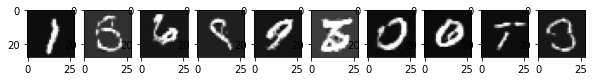

EPOCH : 172 GLOSS: 7.1963019371032715 DLOSS: 0.014628049917519093
EPOCH : 173 GLOSS: 7.000781059265137 DLOSS: 0.009586954489350319
EPOCH : 174 GLOSS: 6.402078628540039 DLOSS: 0.01538120023906231
EPOCH : 175 GLOSS: 6.613595962524414 DLOSS: 0.01699901930987835
EPOCH : 176 GLOSS: 8.88347053527832 DLOSS: 0.008069032803177834
EPOCH : 177 GLOSS: 7.340567111968994 DLOSS: 0.009981737472116947
EPOCH : 178 GLOSS: 7.259987831115723 DLOSS: 0.023878442123532295
EPOCH : 179 GLOSS: 6.970917224884033 DLOSS: 0.03525548428297043
EPOCH : 180 GLOSS: 6.783456325531006 DLOSS: 0.011180154047906399
EPOCH : 181 GLOSS: 7.077261924743652 DLOSS: 0.01502077467739582


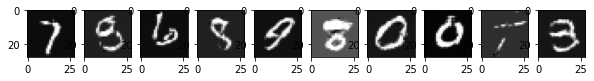

EPOCH : 182 GLOSS: 6.878055572509766 DLOSS: 0.009968539699912071
EPOCH : 183 GLOSS: 5.587738990783691 DLOSS: 0.026154330000281334
EPOCH : 184 GLOSS: 7.545877933502197 DLOSS: 0.02958679012954235
EPOCH : 185 GLOSS: 6.901015758514404 DLOSS: 0.10180345177650452
EPOCH : 186 GLOSS: 5.980506896972656 DLOSS: 0.10860756784677505
EPOCH : 187 GLOSS: 6.651515960693359 DLOSS: 0.010168389417231083
EPOCH : 188 GLOSS: 7.442352771759033 DLOSS: 0.011765321716666222
EPOCH : 189 GLOSS: 6.615435600280762 DLOSS: 0.016666149720549583
EPOCH : 190 GLOSS: 6.808117866516113 DLOSS: 0.027242904528975487
EPOCH : 191 GLOSS: 6.49696159362793 DLOSS: 0.019704598933458328


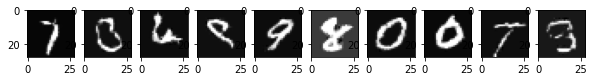

EPOCH : 192 GLOSS: 10.93809700012207 DLOSS: 0.0265541709959507
EPOCH : 193 GLOSS: 6.860614776611328 DLOSS: 0.02909146621823311
EPOCH : 194 GLOSS: 6.860816955566406 DLOSS: 0.016020210459828377
EPOCH : 195 GLOSS: 6.977814674377441 DLOSS: 0.018798429518938065
EPOCH : 196 GLOSS: 6.695528030395508 DLOSS: 0.010956845246255398
EPOCH : 197 GLOSS: 5.937114238739014 DLOSS: 0.02077489346265793
EPOCH : 198 GLOSS: 7.892531394958496 DLOSS: 0.026701774448156357
EPOCH : 199 GLOSS: 5.9551682472229 DLOSS: 0.012117791920900345
EPOCH : 200 GLOSS: 7.204034805297852 DLOSS: 0.017289504408836365
EPOCH : 201 GLOSS: 6.552422523498535 DLOSS: 0.02767278254032135


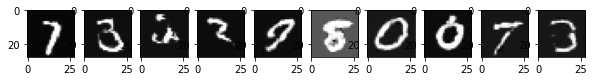

EPOCH : 202 GLOSS: 6.9895734786987305 DLOSS: 0.021547427400946617
EPOCH : 203 GLOSS: 6.974092960357666 DLOSS: 0.015109251253306866
EPOCH : 204 GLOSS: 6.976337909698486 DLOSS: 0.007213505916297436
EPOCH : 205 GLOSS: 9.083134651184082 DLOSS: 0.019768105819821358
EPOCH : 206 GLOSS: 6.825601577758789 DLOSS: 0.009613839909434319
EPOCH : 207 GLOSS: 3.168285369873047 DLOSS: 0.013225946575403214
EPOCH : 208 GLOSS: 5.488284111022949 DLOSS: 0.04194069653749466
EPOCH : 209 GLOSS: 6.553096771240234 DLOSS: 0.019088439643383026
EPOCH : 210 GLOSS: 7.205996036529541 DLOSS: 0.02217680588364601
EPOCH : 211 GLOSS: 5.479208946228027 DLOSS: 0.019047077745199203


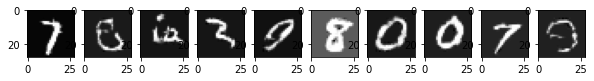

EPOCH : 212 GLOSS: 6.358348846435547 DLOSS: 0.013732393272221088
EPOCH : 213 GLOSS: 6.2768096923828125 DLOSS: 0.014961756765842438
EPOCH : 214 GLOSS: 6.8365702629089355 DLOSS: 0.03210821747779846
EPOCH : 215 GLOSS: 6.044139862060547 DLOSS: 0.024917736649513245
EPOCH : 216 GLOSS: 7.407887935638428 DLOSS: 0.004935420583933592
EPOCH : 217 GLOSS: 6.6666107177734375 DLOSS: 0.015954982489347458
EPOCH : 218 GLOSS: 5.607449531555176 DLOSS: 0.027906306087970734
EPOCH : 219 GLOSS: 6.693334579467773 DLOSS: 0.017155207693576813
EPOCH : 220 GLOSS: 5.500367164611816 DLOSS: 0.028696462512016296
EPOCH : 221 GLOSS: 6.179542541503906 DLOSS: 0.019760923460125923


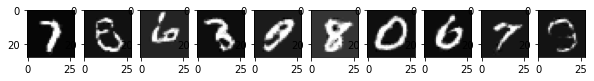

EPOCH : 222 GLOSS: 7.894980430603027 DLOSS: 0.028475534170866013
EPOCH : 223 GLOSS: 6.542804718017578 DLOSS: 0.03667081147432327
EPOCH : 224 GLOSS: 7.571197509765625 DLOSS: 0.021726733073592186
EPOCH : 225 GLOSS: 7.5342864990234375 DLOSS: 0.017432764172554016
EPOCH : 226 GLOSS: 5.882284164428711 DLOSS: 0.015013919211924076
EPOCH : 227 GLOSS: 7.471071720123291 DLOSS: 0.018377024680376053
EPOCH : 228 GLOSS: 6.728297233581543 DLOSS: 0.011299487203359604
EPOCH : 229 GLOSS: 5.884256362915039 DLOSS: 0.06775829941034317
EPOCH : 230 GLOSS: 7.343204021453857 DLOSS: 0.014181999489665031
EPOCH : 231 GLOSS: 1.3327618837356567 DLOSS: 0.015478873625397682


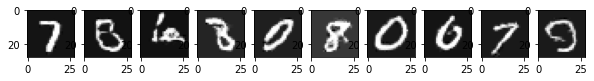

EPOCH : 232 GLOSS: 6.3160810470581055 DLOSS: 0.05082181096076965
EPOCH : 233 GLOSS: 5.501723766326904 DLOSS: 0.018271170556545258
EPOCH : 234 GLOSS: 4.418520927429199 DLOSS: 0.021153748035430908
EPOCH : 235 GLOSS: 4.846433162689209 DLOSS: 0.034338366240262985
EPOCH : 236 GLOSS: 5.9981279373168945 DLOSS: 0.019818652421236038
EPOCH : 237 GLOSS: 5.457165718078613 DLOSS: 0.033209703862667084
EPOCH : 238 GLOSS: 6.542194366455078 DLOSS: 0.03101818636059761
EPOCH : 239 GLOSS: 6.990208148956299 DLOSS: 0.014551692642271519
EPOCH : 240 GLOSS: 6.489164352416992 DLOSS: 0.0425204262137413
EPOCH : 241 GLOSS: 6.819966793060303 DLOSS: 0.026981215924024582


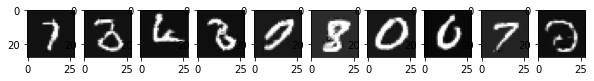

EPOCH : 242 GLOSS: 5.631291389465332 DLOSS: 0.03360704705119133
EPOCH : 243 GLOSS: 4.557531356811523 DLOSS: 0.09196782857179642
EPOCH : 244 GLOSS: 6.729153633117676 DLOSS: 0.01969669573009014
EPOCH : 245 GLOSS: 5.189150333404541 DLOSS: 0.02171451970934868
EPOCH : 246 GLOSS: 4.992275238037109 DLOSS: 0.6911630630493164
EPOCH : 247 GLOSS: 4.993166923522949 DLOSS: 0.03117121011018753
EPOCH : 248 GLOSS: 6.243117809295654 DLOSS: 0.026252781972289085
EPOCH : 249 GLOSS: 5.931840419769287 DLOSS: 0.02051239274442196
EPOCH : 250 GLOSS: 5.577277183532715 DLOSS: 0.028519324958324432
EPOCH : 251 GLOSS: 6.326373100280762 DLOSS: 0.03945237398147583


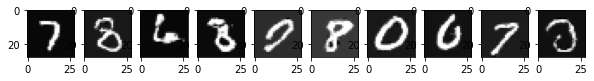

EPOCH : 252 GLOSS: 6.472444534301758 DLOSS: 0.04416550323367119
EPOCH : 253 GLOSS: 4.252071857452393 DLOSS: 0.04712414741516113
EPOCH : 254 GLOSS: 5.621505260467529 DLOSS: 0.045059580355882645
EPOCH : 255 GLOSS: 6.295536041259766 DLOSS: 0.06315699964761734
EPOCH : 256 GLOSS: 4.9587578773498535 DLOSS: 0.028303243219852448
EPOCH : 257 GLOSS: 6.801718235015869 DLOSS: 0.0397665873169899
EPOCH : 258 GLOSS: 4.901294708251953 DLOSS: 0.10057333111763
EPOCH : 259 GLOSS: 5.494083404541016 DLOSS: 0.01879621297121048
EPOCH : 260 GLOSS: 6.994298934936523 DLOSS: 0.04937324300408363
EPOCH : 261 GLOSS: 5.404565811157227 DLOSS: 0.026849545538425446


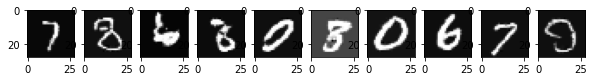

EPOCH : 262 GLOSS: 7.559319019317627 DLOSS: 0.022264719009399414
EPOCH : 263 GLOSS: 5.272248268127441 DLOSS: 0.060005027800798416
EPOCH : 264 GLOSS: 4.596712112426758 DLOSS: 0.03876368701457977
EPOCH : 265 GLOSS: 5.640251159667969 DLOSS: 0.05657792463898659
EPOCH : 266 GLOSS: 6.7516279220581055 DLOSS: 0.01877581514418125
EPOCH : 267 GLOSS: 5.894040584564209 DLOSS: 0.022157996892929077
EPOCH : 268 GLOSS: 5.200143814086914 DLOSS: 0.021077753975987434
EPOCH : 269 GLOSS: 5.343958854675293 DLOSS: 0.028652850538492203
EPOCH : 270 GLOSS: 5.455202102661133 DLOSS: 0.0498025007545948
EPOCH : 271 GLOSS: 6.96594762802124 DLOSS: 0.03617143630981445


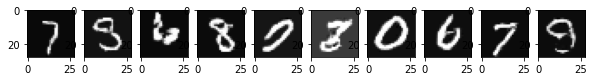

EPOCH : 272 GLOSS: 6.713983535766602 DLOSS: 0.024202201515436172
EPOCH : 273 GLOSS: 6.6082963943481445 DLOSS: 0.0364694744348526
EPOCH : 274 GLOSS: 5.811003684997559 DLOSS: 0.02691107988357544
EPOCH : 275 GLOSS: 5.577940940856934 DLOSS: 0.042404644191265106
EPOCH : 276 GLOSS: 6.1563005447387695 DLOSS: 0.03879227489233017
EPOCH : 277 GLOSS: 5.196174621582031 DLOSS: 0.02911522053182125
EPOCH : 278 GLOSS: 6.4341630935668945 DLOSS: 0.032507382333278656
EPOCH : 279 GLOSS: 5.241324424743652 DLOSS: 0.04166969284415245
EPOCH : 280 GLOSS: 5.282180309295654 DLOSS: 0.1173822358250618
EPOCH : 281 GLOSS: 6.881874084472656 DLOSS: 0.05684984475374222


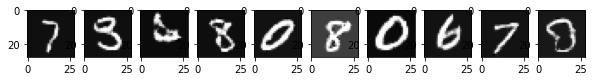

EPOCH : 282 GLOSS: 9.55657958984375 DLOSS: 0.012874996289610863
EPOCH : 283 GLOSS: 5.037954330444336 DLOSS: 0.03667587786912918
EPOCH : 284 GLOSS: 5.194307327270508 DLOSS: 0.09093263000249863
EPOCH : 285 GLOSS: 6.815245628356934 DLOSS: 0.07294048368930817
EPOCH : 286 GLOSS: 4.95088005065918 DLOSS: 0.040297530591487885
EPOCH : 287 GLOSS: 4.965836524963379 DLOSS: 0.02971717342734337
EPOCH : 288 GLOSS: 7.280884742736816 DLOSS: 0.038044799119234085
EPOCH : 289 GLOSS: 5.096557140350342 DLOSS: 0.04170535132288933
EPOCH : 290 GLOSS: 6.293124198913574 DLOSS: 0.030088059604167938
EPOCH : 291 GLOSS: 6.797751426696777 DLOSS: 0.12598180770874023


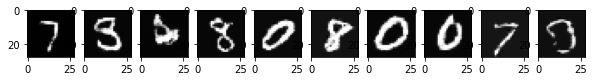

EPOCH : 292 GLOSS: 5.379729747772217 DLOSS: 0.04694797843694687
EPOCH : 293 GLOSS: 3.830989360809326 DLOSS: 0.06710869818925858
EPOCH : 294 GLOSS: 6.796125411987305 DLOSS: 0.04565506428480148
EPOCH : 295 GLOSS: 4.346778392791748 DLOSS: 0.04765636473894119
EPOCH : 296 GLOSS: 5.217509746551514 DLOSS: 0.026234187185764313
EPOCH : 297 GLOSS: 6.600522994995117 DLOSS: 0.10243163257837296
EPOCH : 298 GLOSS: 4.647058010101318 DLOSS: 0.03030552715063095
EPOCH : 299 GLOSS: 8.107162475585938 DLOSS: 0.07592932879924774
EPOCH : 300 GLOSS: 6.680316925048828 DLOSS: 0.08164893835783005
EPOCH : 301 GLOSS: 6.91025447845459 DLOSS: 0.032384078949689865


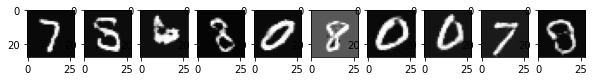

EPOCH : 302 GLOSS: 7.224261283874512 DLOSS: 0.0554000586271286
EPOCH : 303 GLOSS: 4.587080001831055 DLOSS: 0.01298914197832346
EPOCH : 304 GLOSS: 5.548442363739014 DLOSS: 0.027296964079141617
EPOCH : 305 GLOSS: 6.819708347320557 DLOSS: 0.02173168957233429
EPOCH : 306 GLOSS: 6.574098110198975 DLOSS: 0.020125677809119225
EPOCH : 307 GLOSS: 5.483348846435547 DLOSS: 0.04215720295906067
EPOCH : 308 GLOSS: 7.3887434005737305 DLOSS: 0.01797310821712017
EPOCH : 309 GLOSS: 7.035902976989746 DLOSS: 0.0410732738673687
EPOCH : 310 GLOSS: 4.75129508972168 DLOSS: 0.04589118808507919
EPOCH : 311 GLOSS: 6.570988178253174 DLOSS: 0.032951969653367996


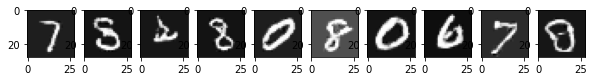

EPOCH : 312 GLOSS: 8.119396209716797 DLOSS: 0.048310235142707825
EPOCH : 313 GLOSS: 6.7997965812683105 DLOSS: 0.05077827349305153
EPOCH : 314 GLOSS: 4.641097068786621 DLOSS: 0.05421639606356621
EPOCH : 315 GLOSS: 4.724700927734375 DLOSS: 0.04300117492675781
EPOCH : 316 GLOSS: 5.964534282684326 DLOSS: 0.023353420197963715
EPOCH : 317 GLOSS: 7.759378433227539 DLOSS: 0.04940222576260567
EPOCH : 318 GLOSS: 9.396743774414062 DLOSS: 0.08390925079584122
EPOCH : 319 GLOSS: 6.6569061279296875 DLOSS: 0.015956275165081024
EPOCH : 320 GLOSS: 4.003230094909668 DLOSS: 0.02682516537606716
EPOCH : 321 GLOSS: 6.148462295532227 DLOSS: 0.024654142558574677


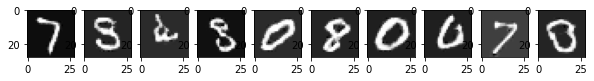

EPOCH : 322 GLOSS: 5.59227180480957 DLOSS: 0.017572715878486633
EPOCH : 323 GLOSS: 5.388078212738037 DLOSS: 0.018073933199048042
EPOCH : 324 GLOSS: 5.591289520263672 DLOSS: 0.023107746616005898
EPOCH : 325 GLOSS: 4.965984344482422 DLOSS: 0.03140856698155403
EPOCH : 326 GLOSS: 6.781503200531006 DLOSS: 0.028837837278842926
EPOCH : 327 GLOSS: 4.619194030761719 DLOSS: 0.09960798919200897
EPOCH : 328 GLOSS: 4.904911994934082 DLOSS: 0.02116699144244194
EPOCH : 329 GLOSS: 7.273126602172852 DLOSS: 0.02739536389708519
EPOCH : 330 GLOSS: 12.180118560791016 DLOSS: 0.017377018928527832
EPOCH : 331 GLOSS: 3.9206204414367676 DLOSS: 0.14894405007362366


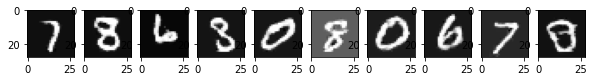

EPOCH : 332 GLOSS: 4.616975784301758 DLOSS: 0.05193805694580078
EPOCH : 333 GLOSS: 5.219836235046387 DLOSS: 0.022129535675048828
EPOCH : 334 GLOSS: 4.934435844421387 DLOSS: 0.03612072020769119
EPOCH : 335 GLOSS: 6.126591682434082 DLOSS: 0.054497405886650085
EPOCH : 336 GLOSS: 7.102780342102051 DLOSS: 0.040205396711826324
EPOCH : 337 GLOSS: 5.773956775665283 DLOSS: 0.02774408832192421
EPOCH : 338 GLOSS: 4.674811363220215 DLOSS: 0.04761326313018799
EPOCH : 339 GLOSS: 5.781607151031494 DLOSS: 0.025945084169507027
EPOCH : 340 GLOSS: 6.982166290283203 DLOSS: 0.05187471583485603
EPOCH : 341 GLOSS: 5.157773017883301 DLOSS: 0.03127843886613846


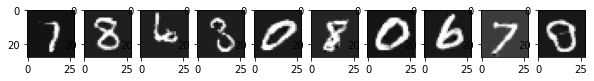

EPOCH : 342 GLOSS: 7.583635330200195 DLOSS: 0.020848028361797333
EPOCH : 343 GLOSS: 7.6197590827941895 DLOSS: 0.23331031203269958
EPOCH : 344 GLOSS: 5.405664443969727 DLOSS: 0.035105664283037186
EPOCH : 345 GLOSS: 5.4202165603637695 DLOSS: 0.03409437835216522
EPOCH : 346 GLOSS: 6.454643249511719 DLOSS: 0.05229949951171875
EPOCH : 347 GLOSS: 6.515873432159424 DLOSS: 0.03530837222933769
EPOCH : 348 GLOSS: 5.391490936279297 DLOSS: 0.03247673436999321
EPOCH : 349 GLOSS: 5.145273208618164 DLOSS: 0.04629978537559509
EPOCH : 350 GLOSS: 6.726982116699219 DLOSS: 0.16514623165130615
EPOCH : 351 GLOSS: 7.673673629760742 DLOSS: 0.05777013301849365


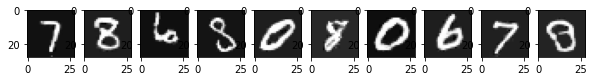

EPOCH : 352 GLOSS: 5.108896732330322 DLOSS: 0.5818479657173157
EPOCH : 353 GLOSS: 5.362813472747803 DLOSS: 0.051351919770240784
EPOCH : 354 GLOSS: 5.252164840698242 DLOSS: 0.01781744696199894
EPOCH : 355 GLOSS: 5.233589172363281 DLOSS: 0.03397630900144577
EPOCH : 356 GLOSS: 5.724685192108154 DLOSS: 0.019875284284353256
EPOCH : 357 GLOSS: 6.056620121002197 DLOSS: 0.0771283507347107
EPOCH : 358 GLOSS: 5.940188407897949 DLOSS: 0.03429084271192551
EPOCH : 359 GLOSS: 5.606064319610596 DLOSS: 0.027722418308258057
EPOCH : 360 GLOSS: 5.0214996337890625 DLOSS: 0.06425442546606064
EPOCH : 361 GLOSS: 6.348957061767578 DLOSS: 0.023149523884058


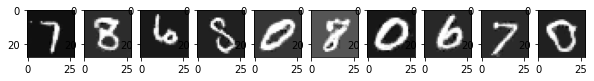

EPOCH : 362 GLOSS: 4.9857048988342285 DLOSS: 0.03141135722398758
EPOCH : 363 GLOSS: 5.591280460357666 DLOSS: 0.03272164240479469
EPOCH : 364 GLOSS: 7.073625087738037 DLOSS: 0.06916920840740204
EPOCH : 365 GLOSS: 5.312912940979004 DLOSS: 0.0987202525138855
EPOCH : 366 GLOSS: 6.213284492492676 DLOSS: 0.014365514740347862
EPOCH : 367 GLOSS: 5.602513790130615 DLOSS: 0.030974391847848892
EPOCH : 368 GLOSS: 6.251916885375977 DLOSS: 0.16302700340747833
EPOCH : 369 GLOSS: 3.982997179031372 DLOSS: 0.06379938125610352
EPOCH : 370 GLOSS: 6.990644931793213 DLOSS: 0.03319288790225983
EPOCH : 371 GLOSS: 5.4376630783081055 DLOSS: 0.02465725690126419


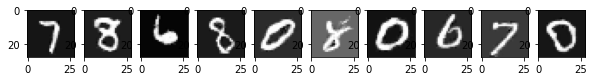

EPOCH : 372 GLOSS: 4.632157325744629 DLOSS: 0.035327065736055374
EPOCH : 373 GLOSS: 5.994293212890625 DLOSS: 0.8246514201164246
EPOCH : 374 GLOSS: 5.800135612487793 DLOSS: 0.039293233305215836
EPOCH : 375 GLOSS: 5.4780120849609375 DLOSS: 0.021044883877038956
EPOCH : 376 GLOSS: 6.183555603027344 DLOSS: 0.035640373826026917
EPOCH : 377 GLOSS: 6.280436992645264 DLOSS: 0.08572780340909958
EPOCH : 378 GLOSS: 4.4138336181640625 DLOSS: 0.03273845836520195
EPOCH : 379 GLOSS: 5.8759894371032715 DLOSS: 0.020305674523115158
EPOCH : 380 GLOSS: 6.336928844451904 DLOSS: 0.05108709633350372
EPOCH : 381 GLOSS: 5.241665840148926 DLOSS: 0.03989773988723755


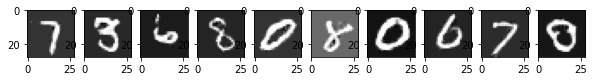

EPOCH : 382 GLOSS: 5.6075239181518555 DLOSS: 0.030173588544130325
EPOCH : 383 GLOSS: 5.478694438934326 DLOSS: 0.026995684951543808
EPOCH : 384 GLOSS: 7.861766338348389 DLOSS: 0.15237024426460266
EPOCH : 385 GLOSS: 4.965066909790039 DLOSS: 0.019007030874490738
EPOCH : 386 GLOSS: 5.288435935974121 DLOSS: 0.019933849573135376
EPOCH : 387 GLOSS: 5.186112403869629 DLOSS: 0.037453848868608475
EPOCH : 388 GLOSS: 5.058810234069824 DLOSS: 0.11411357671022415
EPOCH : 389 GLOSS: 5.765644073486328 DLOSS: 0.028309917077422142
EPOCH : 390 GLOSS: 5.422391891479492 DLOSS: 0.052847009152173996
EPOCH : 391 GLOSS: 4.914392471313477 DLOSS: 0.0765247493982315


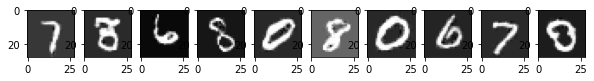

EPOCH : 392 GLOSS: 5.633378982543945 DLOSS: 0.026774052530527115
EPOCH : 393 GLOSS: 6.563762664794922 DLOSS: 0.064897820353508
EPOCH : 394 GLOSS: 6.545485496520996 DLOSS: 0.024520236998796463
EPOCH : 395 GLOSS: 5.960167407989502 DLOSS: 0.08215232193470001
EPOCH : 396 GLOSS: 5.050899505615234 DLOSS: 0.03911365568637848
EPOCH : 397 GLOSS: 6.0455708503723145 DLOSS: 0.04734663665294647
EPOCH : 398 GLOSS: 6.92271614074707 DLOSS: 0.01475057564675808
EPOCH : 399 GLOSS: 5.628427505493164 DLOSS: 0.035061560571193695
EPOCH : 400 GLOSS: 5.922068119049072 DLOSS: 0.09566934406757355
EPOCH : 401 GLOSS: 5.897992134094238 DLOSS: 0.021979771554470062


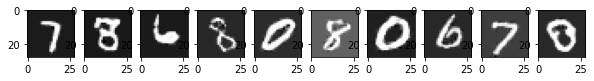

EPOCH : 402 GLOSS: 5.070790767669678 DLOSS: 0.11922627687454224
EPOCH : 403 GLOSS: 4.597844123840332 DLOSS: 0.09339482337236404
EPOCH : 404 GLOSS: 3.9761250019073486 DLOSS: 0.06584321707487106
EPOCH : 405 GLOSS: 4.56186580657959 DLOSS: 0.035162702202796936
EPOCH : 406 GLOSS: 4.685851097106934 DLOSS: 0.02646823413670063
EPOCH : 407 GLOSS: 5.734805583953857 DLOSS: 0.017787422984838486
EPOCH : 408 GLOSS: 6.055327415466309 DLOSS: 0.10482235252857208
EPOCH : 409 GLOSS: 3.9627790451049805 DLOSS: 0.14147570729255676
EPOCH : 410 GLOSS: 4.733672142028809 DLOSS: 0.05049579590559006
EPOCH : 411 GLOSS: 4.637162208557129 DLOSS: 0.036568544805049896


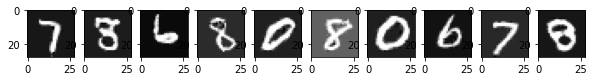

EPOCH : 412 GLOSS: 5.685413360595703 DLOSS: 0.030022691935300827
EPOCH : 413 GLOSS: 5.837718486785889 DLOSS: 0.040740929543972015
EPOCH : 414 GLOSS: 5.199208736419678 DLOSS: 0.03935542702674866
EPOCH : 415 GLOSS: 6.391462326049805 DLOSS: 0.0266129057854414
EPOCH : 416 GLOSS: 5.819361209869385 DLOSS: 0.028675762936472893
EPOCH : 417 GLOSS: 6.447103977203369 DLOSS: 0.018940843641757965
EPOCH : 418 GLOSS: 5.109023094177246 DLOSS: 0.04511848837137222
EPOCH : 419 GLOSS: 6.386468887329102 DLOSS: 0.021228620782494545
EPOCH : 420 GLOSS: 4.7739362716674805 DLOSS: 0.04781007766723633
EPOCH : 421 GLOSS: 5.317883491516113 DLOSS: 0.05160396546125412


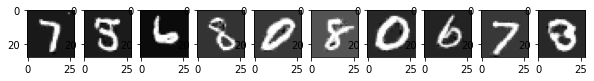

EPOCH : 422 GLOSS: 5.872701644897461 DLOSS: 0.031546320766210556
EPOCH : 423 GLOSS: 6.366616249084473 DLOSS: 0.03330392763018608
EPOCH : 424 GLOSS: 5.673872947692871 DLOSS: 0.030875742435455322
EPOCH : 425 GLOSS: 4.913320541381836 DLOSS: 0.2637424170970917
EPOCH : 426 GLOSS: 6.545731544494629 DLOSS: 0.03135858476161957
EPOCH : 427 GLOSS: 6.1402082443237305 DLOSS: 0.052097998559474945
EPOCH : 428 GLOSS: 5.486587047576904 DLOSS: 0.029670197516679764
EPOCH : 429 GLOSS: 6.59724235534668 DLOSS: 0.04338431730866432
EPOCH : 430 GLOSS: 5.776244163513184 DLOSS: 0.02407084032893181
EPOCH : 431 GLOSS: 5.52729606628418 DLOSS: 0.07250519096851349


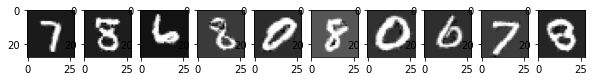

EPOCH : 432 GLOSS: 8.5628080368042 DLOSS: 0.14222227036952972
EPOCH : 433 GLOSS: 5.261587142944336 DLOSS: 0.05968371406197548
EPOCH : 434 GLOSS: 5.356748104095459 DLOSS: 0.02985004335641861
EPOCH : 435 GLOSS: 6.113863468170166 DLOSS: 0.03337739035487175
EPOCH : 436 GLOSS: 5.416851997375488 DLOSS: 0.0600951611995697
EPOCH : 437 GLOSS: 5.982335090637207 DLOSS: 0.05113174021244049
EPOCH : 438 GLOSS: 6.365769863128662 DLOSS: 0.026926811784505844
EPOCH : 439 GLOSS: 4.945931434631348 DLOSS: 0.0359751395881176
EPOCH : 440 GLOSS: 6.561854362487793 DLOSS: 0.013756864704191685
EPOCH : 441 GLOSS: 7.689609527587891 DLOSS: 0.03951118886470795


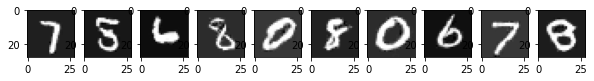

EPOCH : 442 GLOSS: 5.8236260414123535 DLOSS: 0.017400652170181274
EPOCH : 443 GLOSS: 5.700459957122803 DLOSS: 0.03272455185651779
EPOCH : 444 GLOSS: 5.5443572998046875 DLOSS: 0.04025919735431671
EPOCH : 445 GLOSS: 7.431139945983887 DLOSS: 0.03807047754526138
EPOCH : 446 GLOSS: 7.134821891784668 DLOSS: 0.1047247052192688
EPOCH : 447 GLOSS: 5.179440021514893 DLOSS: 0.04918922483921051
EPOCH : 448 GLOSS: 7.678082466125488 DLOSS: 0.024278512224555016
EPOCH : 449 GLOSS: 5.6047797203063965 DLOSS: 0.02046290971338749
EPOCH : 450 GLOSS: 6.074456691741943 DLOSS: 0.023194139823317528
EPOCH : 451 GLOSS: 7.0480780601501465 DLOSS: 0.027972670271992683


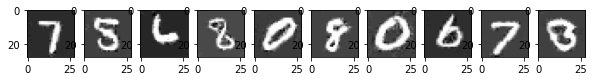

EPOCH : 452 GLOSS: 8.618097305297852 DLOSS: 0.2901829183101654
EPOCH : 453 GLOSS: 5.427825450897217 DLOSS: 0.04588408023118973
EPOCH : 454 GLOSS: 4.4483771324157715 DLOSS: 0.12691476941108704
EPOCH : 455 GLOSS: 4.7325053215026855 DLOSS: 0.030201885849237442
EPOCH : 456 GLOSS: 5.924753189086914 DLOSS: 0.020253341645002365
EPOCH : 457 GLOSS: 6.033642768859863 DLOSS: 0.021776210516691208
EPOCH : 458 GLOSS: 5.459310054779053 DLOSS: 0.023970521986484528
EPOCH : 459 GLOSS: 5.607008934020996 DLOSS: 0.026265520602464676
EPOCH : 460 GLOSS: 6.216948986053467 DLOSS: 0.026759611442685127
EPOCH : 461 GLOSS: 6.697716236114502 DLOSS: 0.04030109941959381


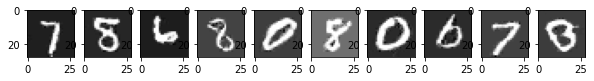

EPOCH : 462 GLOSS: 5.076229095458984 DLOSS: 0.045828886330127716
EPOCH : 463 GLOSS: 4.777681350708008 DLOSS: 0.05203738063573837
EPOCH : 464 GLOSS: 4.656420707702637 DLOSS: 0.04652173072099686
EPOCH : 465 GLOSS: 6.56607723236084 DLOSS: 0.029556846246123314
EPOCH : 466 GLOSS: 5.718572616577148 DLOSS: 0.14080370962619781
EPOCH : 467 GLOSS: 5.831348419189453 DLOSS: 0.03699776902794838
EPOCH : 468 GLOSS: 8.071403503417969 DLOSS: 0.018161090090870857
EPOCH : 469 GLOSS: 8.253396034240723 DLOSS: 0.017938872799277306
EPOCH : 470 GLOSS: 7.90037727355957 DLOSS: 0.047084029763936996
EPOCH : 471 GLOSS: 10.135615348815918 DLOSS: 0.06282136589288712


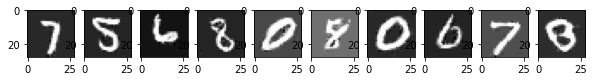

EPOCH : 472 GLOSS: 4.999793529510498 DLOSS: 0.027766864746809006
EPOCH : 473 GLOSS: 5.701800346374512 DLOSS: 0.01238265261054039
EPOCH : 474 GLOSS: 6.164167881011963 DLOSS: 0.013896691612899303
EPOCH : 475 GLOSS: 6.129770278930664 DLOSS: 0.012552859261631966
EPOCH : 476 GLOSS: 5.364528656005859 DLOSS: 0.024412352591753006
EPOCH : 477 GLOSS: 5.8467912673950195 DLOSS: 0.01680036447942257
EPOCH : 478 GLOSS: 5.170339584350586 DLOSS: 0.01785636693239212
EPOCH : 479 GLOSS: 8.019885063171387 DLOSS: 0.013907487504184246
EPOCH : 480 GLOSS: 5.031185150146484 DLOSS: 0.02014845609664917
EPOCH : 481 GLOSS: 4.982586860656738 DLOSS: 0.09631428867578506


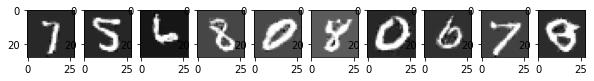

EPOCH : 482 GLOSS: 5.2527666091918945 DLOSS: 0.034897636622190475
EPOCH : 483 GLOSS: 6.856638431549072 DLOSS: 0.030963005498051643
EPOCH : 484 GLOSS: 5.635512351989746 DLOSS: 0.02230922505259514
EPOCH : 485 GLOSS: 6.4267377853393555 DLOSS: 0.011782890185713768
EPOCH : 486 GLOSS: 5.375133991241455 DLOSS: 0.02447013556957245
EPOCH : 487 GLOSS: 5.201357841491699 DLOSS: 0.02127179503440857
EPOCH : 488 GLOSS: 5.161069869995117 DLOSS: 0.019389944151043892
EPOCH : 489 GLOSS: 5.864198684692383 DLOSS: 0.01983419805765152
EPOCH : 490 GLOSS: 5.243908405303955 DLOSS: 0.018556132912635803
EPOCH : 491 GLOSS: 4.996639251708984 DLOSS: 0.04127040505409241


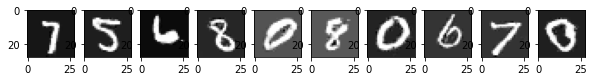

EPOCH : 492 GLOSS: 4.710315704345703 DLOSS: 0.026704952120780945
EPOCH : 493 GLOSS: 5.739279747009277 DLOSS: 0.016135796904563904
EPOCH : 494 GLOSS: 6.55145263671875 DLOSS: 0.031760603189468384
EPOCH : 495 GLOSS: 7.836233615875244 DLOSS: 0.016783472150564194
EPOCH : 496 GLOSS: 4.860051155090332 DLOSS: 0.037745535373687744
EPOCH : 497 GLOSS: 6.842590808868408 DLOSS: 0.011507214047014713
EPOCH : 498 GLOSS: 5.397481918334961 DLOSS: 0.02392730303108692
EPOCH : 499 GLOSS: 7.562838554382324 DLOSS: 0.04174093157052994
EPOCH : 500 GLOSS: 6.046534061431885 DLOSS: 0.13661633431911469


In [10]:
real_images_arr = []

for i, (image, label) in enumerate(data_loader):
    real_images_arr.append(image.to(device).view(-1, 1, 28, 28))

for i in range(epoch):
    for real_images in real_images_arr:
        random_noises = generate_noise(batch_size, noise_dim)
        fake_images = G(random_noises)
        real_outs = D(real_images)
        fake_outs = D(fake_images)
        
        D_loss = criterion(real_outs, real_labels) + criterion(fake_outs, fake_labels)
        
        D_optim.zero_grad()
        G_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        
        fake_images = G(random_noises)
        outputs = D(fake_images)
        G_loss = criterion(outputs, real_labels)

        D_optim.zero_grad()
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

    print("EPOCH :", i + 1, "GLOSS:", G_loss.item(), "DLOSS:", D_loss.item())

    if i % print_per == 0:
        generated_images = G(noise_for_print).view(test_len, 28, 28)
        plt.figure(figsize = (10, 100))
        for j in range(test_len):
            plt.subplot(1, test_len, j + 1)
            idx = idx + 1
            plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
        plt.show()

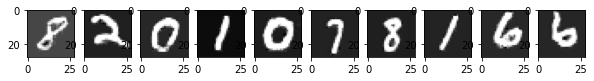

In [19]:
noise_for_print = generate_noise(test_len, noise_dim)
generated_images = G(noise_for_print).view(test_len, 28, 28)
plt.figure(figsize = (10, 100))
for j in range(test_len):
    plt.subplot(1, test_len, j + 1)
    idx = idx + 1
    plt.imshow(generated_images.detach().cpu().numpy()[j], cmap = 'gray')
plt.show()